In [2]:
import soundfile as sf
import numpy as np
import scipy as signal
import matplotlib.pyplot as plt
import math
import pandas as pd
import itertools

In [4]:
# Reference: http://www.xavieranguera.com/phdthesis/node92.html

In [2]:
# Load data
data1,samplerate = sf.read('/Users/yihanhu/Desktop/CSE4223/Data/postfiltered_2020-08-19_11_40_03_2.raw', 
               channels=4, 
               samplerate=16000,
               subtype='PCM_16'
              )
data2,samplerate = sf.read('/Users/yihanhu/Desktop/CSE4223/Data/postfiltered_2020-08-19_11_40_03_5.raw', 
               channels=4, 
               samplerate=16000,
               subtype='PCM_16'
              )

In [ ]:
# Source Matching Design
# A couple more things that I can look at is the activity in the log file, need to incorporate that with the sound files
# hmmmmmmmmm

# 

In [3]:
# Functions
def truncate(sig1, sig2):
    '''
    This function truncates the longer signal and return two signals of the same length
    '''
    l1, l2 = len(sig1), len(sig2)
    if l1 <= l2:
        return sig1, sig2[0:l1]
    else:
        return sig1[0:l2], sig2
    
def padding(sig1, sig2):
    '''
    This function pads the shorter sequence to the length of longer sequence with 0
    '''
    length = np.maximum(len(sig1), len(sig2))
    l1, l2 = len(sig1), len(sig2)
    if l1 < length:
        return np.concatenate((sig1, np.linspace(0,0,length - l1))), sig2
    if l2 < length:
        return sig1, np.concatenate((sig2, np.linspace(0,0,length - l2)))

def prepadding(sig1, sig2, winDuration, Fs):
    l = winDuration * Fs
    N = len(sig1)    
    # Padding to have an interger number of windows
    if N%l != 0:
        padWidth = l-N%l
        sig1 = np.pad(sig1, (0, padWidth), 'constant', constant_values = 0)
        sig2 = np.pad(sig2, (0, padWidth), 'constant', constant_values = 0)
        
    numOfWindows = len(sig1)/l
    
    return sig1, sig2, numOfWindows

def whiten(sig):
    return sig/np.abs(sig)

def gcc_phat(sig1, sig2, fs=16000, max_tau=None, interp=1, window=True, windowName="hamming"):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT)method. In this modified
    function, sig1 and sig2 are garuanteed to have the same length
    '''
    # Make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    # n1, n2 = sig1.shape[0], sig2.shape[0]
    n = sig1.shape[0]
    
    # Add window
    if window: 
        win1 = getattr(np, windowName)(n)
        win2 = getattr(np, windowName)(n)
        sig1 = sig1 * win1
        sig2 = sig2 * win2

    # Generalized Cross Correlation Phase Transform
    SIG1 = np.fft.rfft(sig1, n=n)
    SIG2 = np.fft.rfft(sig2, n=n)
    
    W1 = whiten(SIG1)
    W2 = whiten(SIG2)
    
    R = W1 * np.conj(W2)
    
    cc = np.fft.irfft(R, n=(interp * n))

    # cc = np.fft.irfft(R / np.abs(R), n=(interp * n))

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # find max cross correlation index
    shift = np.argmax(np.abs(cc)) - max_shift

    tau = np.float(shift / float(interp * fs))
    
    if(np.any(np.isnan(cc))): 
        tau = math.nan
    
    return tau, cc, R, SIG1, SIG2


def width_cc(cc, threshold=0.5):
    '''
    Calculate the width between the first sample and the last sample that are above the thresold.
    Threshold is precentage of the peak value
    '''
    cc_max = np.amax(cc)
    peak_index = np.where(cc == cc_max)
    mag_thr = threshold * cc_max
    width = 0
    for ii in range(len(cc)):
        if cc[ii] > mag_thr:
            width = width + 1
    return width

def significance(cc):
    '''
    Calculate the significance of each cross correlation sequence
    '''
    cc_mean = np.mean(cc)
    cc_std = np.std(cc)
    return (np.amax(cc) - cc_mean)/cc_std

In [10]:
# plot the location of time for different window sizes 04/01/2020
def cc_analysis(data1, data2, fraction, channel1 = 0, channel2 = 0):
    # Initialize empty arrays
    sig1, sig2 = padding(data1[:,channel1], data2[:,channel2])
    Fs = 16000
    total_time = int(np.minimum(len(data1), len(data2))/Fs)
    window_len = fraction * total_time # how many seconds in a window
    l = Fs * window_len
    num_slices = int(total_time / window_len) # how many windows in a time sequence
    cc_len = int(2 * l + 1)
    cc_all = np.zeros((num_slices, cc_len))
    cc_peak = np.zeros((num_slices))
    time_vector = np.linspace(1,num_slices, num_slices)
    delay_vector = np.zeros(num_slices)
    width_vector = np.zeros(num_slices)
    z_vector = np.zeros(num_slices)
    for ii in range(num_slices):
        sig1Temp, sig2Temp = sig1[int(ii * l):int((ii + 1)* l)], sig2[int(ii * l):int((ii + 1)* l)]
        tau, cc, R, SIG1, SIG2 = gcc_phat(sig1Temp, sig2Temp, fs = Fs, max_tau=None, interp=2, window=True, windowName="hamming")
        cc_peak[ii] = np.argmax(np.abs(cc))
        cc_all[ii,:] = cc
        delay_vector[ii] = tau
        width_vector[ii] = width_cc(cc)
        z_vector[ii] = significance(cc)
    #cc_all = cc_all.reshape((num_slices * cc_len))
    return num_slices, window_len, cc_all, cc_peak, delay_vector, width_vector, z_vector

In [11]:
fraction_list = [1/100, 1/200, 1/500, 1/1000]
# total_time = int(np.minimum(len(data1), len(data2))/Fs)
# window_len = fraction * total_time # how many seconds in a window
# num_slices = int(total_time / window_len)
# list_len = len(fraction_list)
# num_slices_list = np.zeros(list_len)
# window_len_list = np.zeros(list_len)
# cc_peak_list = np.zeros(list_len, num_slices)
# delay_vector_list = np.zeros()
num_slices1, window_len1, cc_all1, cc_peak1, delay_vector1, width_vector1, z_vector1 = cc_analysis(data1, data2, fraction = fraction_list[0], channel1 = 0, channel2 = 0)
num_slices2, window_len2, cc_all2, cc_peak2, delay_vector2, width_vector2, z_vector2 = cc_analysis(data1, data2, fraction = fraction_list[1], channel1 = 0, channel2 = 0)
num_slices3, window_len3, cc_all3, cc_peak3, delay_vector3, width_vector3, z_vector3 = cc_analysis(data1, data2, fraction = fraction_list[2], channel1 = 0, channel2 = 0)
num_slices4, window_len4, cc_all4, cc_peak4, delay_vector4, width_vector4, z_vector4 = cc_analysis(data1, data2, fraction = fraction_list[3], channel1 = 0, channel2 = 0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, 'cc_magnitude')

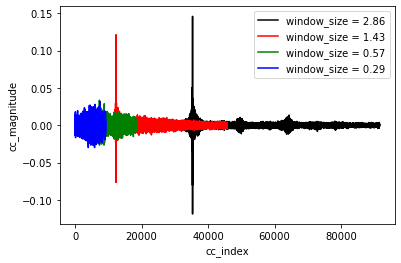

In [19]:
# plot cc results
Fs = 16000
l1, l2, l3, l4 = Fs * window_len1, Fs * window_len2, Fs * window_len3, Fs * window_len4
cc_len1, cc_len2, cc_len3, cc_len4 = int(2 * l1 +1), int(2 * l2 +1), int(2 * l3 +1), int(2 * l4 +1)
x1, x2, x3, x4 = np.linspace(1,cc_len1, cc_len1), np.linspace(1,cc_len2, cc_len2), np.linspace(1,cc_len3, cc_len3), np.linspace(1,cc_len4, cc_len4)
index1, index2, index3, index4 = int(num_slices1 * np.random.random()), int(num_slices2 * np.random.random()), int(num_slices3 * np.random.random()), int(num_slices4 * np.random.random())
y1, y2, y3, y4 = cc_all1[index1,:], cc_all2[index2,:], cc_all3[index3,:], cc_all4[index4,:]
plt.plot(x1, y1, color = 'black', label = 'window_size = '+ str(round(window_len1, 2)))
plt.plot(x2, y2, color = 'red', label = 'window_size = ' + str(round(window_len2, 2)))
plt.plot(x3, y3, color = 'green', label = 'window_size = ' + str(round(window_len3, 2)))
plt.plot(x4, y4, color = 'blue', label = 'window_size = ' + str(round(window_len4, 2)))
plt.legend()
plt.xlabel('cc_index')
plt.ylabel('cc_magnitude')

/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


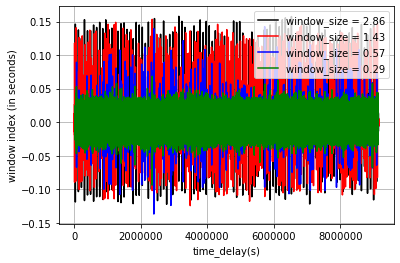

In [9]:
x1 = np.linspace(1,num_slices1 ,num_slices1) * window_len1 
x2 = np.linspace(1,num_slices2 ,num_slices2) * window_len2 
x3 = np.linspace(1,num_slices3 ,num_slices3) * window_len3 
x4 = np.linspace(1,num_slices4 ,num_slices4) * window_len4 

y1 = cc_all1
y2 = cc_all2
y3 = cc_all3
y4 = cc_all4

plt.plot(y1, color = 'black', label = 'window_size = '+ str(round(window_len1, 2)))
plt.plot(y2, color = 'red', label = 'window_size = ' + str(round(window_len2, 2)))
plt.plot(y3, color = 'blue', label = 'window_size = ' + str(round(window_len3, 2)))
plt.plot(y4, color = 'green', label = 'window_size = '+ str(round(window_len4, 2)))
plt.legend()

plt.xlabel('time_delay(s)')
plt.ylabel('window index (in seconds)')
plt.grid()

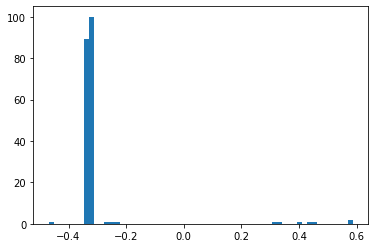

In [35]:
plt.hist(y,bins = 60);

# To Do
todo:
1. use fig size to change figure size
2. Make cells into a function that can be called with different parameters.
***3*** figure out how to make the delay peak insensitive to window size
***4*** plot cross correlation function and see that they become stable.
Test sample = 1 minute of meeting recording
Using window of 2 sec long, do complete analysis of test sample (using current code)
Include in the pandas data frame the (Z normalized) magnitude of the peak and the width of the peak
See if you can filter out the noise using magnitude and width.
Update the code timely!


Histogram of the y value
Change both x-axis to second, and see what will happen with different window sizes

In [39]:
total_time

286

In [42]:
# Return the table 
Fs = 16000
total_time = int(np.minimum(len(data1), len(data2))/Fs)
window_len = 0.01 # how many seconds in a window
l = Fs * window_len
num_slices = int(total_time / window_len)
channel1 = 0
channel2 = 0
# Initialize empty arrays
time_vector = np.linspace(1,num_slices, num_slices)
delay_vector = np.zeros(num_slices)
width_vector = np.zeros(num_slices)
significance_vector = np.zeros(num_slices)
sig1, sig2 = padding(data1[:,channel1], data2[:,channel2])
cc_all = np.zeros((num_slices, int(2*l+1)))
np.argmax(np.abs(cc))
for ii in range(num_slices):
    sig1Temp, sig2Temp = sig1[int(ii * l):int((ii + 1)* l)], sig2[int(ii * l):int((ii + 1)* l)]
    tau, cc, R, SIG1, SIG2 = gcc_phat(sig1Temp, sig2Temp, fs = Fs, max_tau=None, interp=2, window=True, windowName="hamming")
    width1 = width_cc(cc, 0.5)
    significance1 = significance(cc)
    delay_vector[ii] = tau
    width_vector[ii] = width1
    significance_vector[ii] = significance1
    cc_len = len(cc)
    cc_all[ii,:] = cc

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


In [58]:
# len1, len2 = len(sig1), len(sig2)
# tau, cc, R, SIG1, SIG2 = gcc_phat(sig1[10*int(len1/2500):20*int(len1/2500)], sig2[int(len1/2500):2*int(len1/2500)], fs = Fs)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


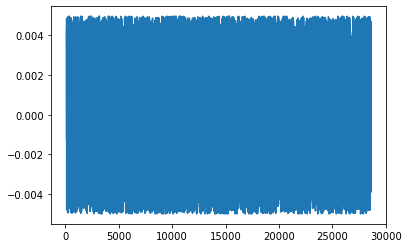

In [14]:
plt.plot(delay_vector)

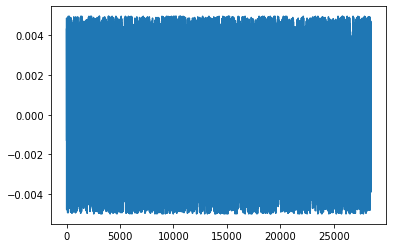

In [32]:
delay_vector_new = np.zeros(len(delay_vector))
count = 0
for jj in range(len(delay_vector)):
    if np.isnan(delay_vector[jj]) == False:
        delay_vector_new[count] = delay_vector[jj]
        count += 1
plt.plot(delay_vector_new[0:count])

In [33]:
delay_vector_new[0]

0.0043125

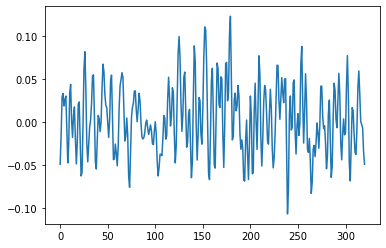

In [53]:
plt.plot(cc_all[10005,:])

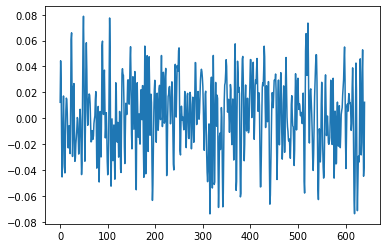

In [12]:
plt.plot(cc)

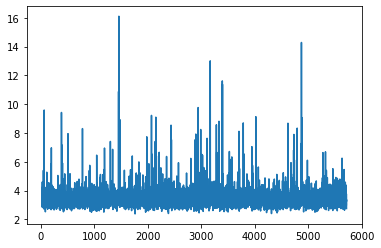

In [63]:
plt.plot(significance_vector)

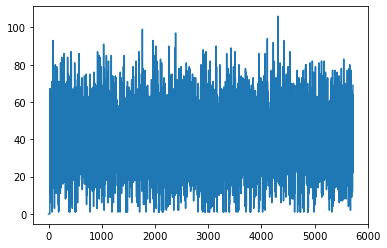

In [12]:
plt.plot(width_vector)

In [42]:
# channel1 = 0
# channel2 = 0
# sig1, sig2 = padding(data1[:,channel1], data2[:,channel2]) 
# #ii = 45
# l = 16000
# tau_list = np.zeros(286)
# tau_sum = 0
# count = 0
# for ii in range(num_slices):
#     sig1, sig2 = truncate(data1[:,channel1], data2[:,channel2])
#     sig1Temp, sig2Temp = sig1[int(ii * l):int((ii + 1)* l)], sig2[int(ii * l):int((ii + 1)* l)]
#     tau, cc, R, SIG1, SIG2 = gcc_phat(sig1Temp, sig2Temp, fs = Fs)
#     width1 = width_cc(cc, 0.5)
#     significance1 = significance(cc)
#     delay_vector[ii] = tau
#     width_vector[ii] = width1
#     significance_vector[ii] = significance1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


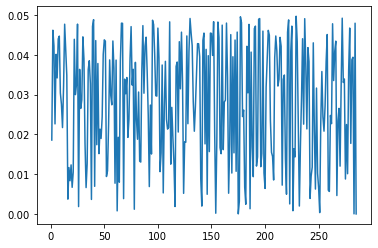

In [43]:
plt.plot(np.abs(tau_list))

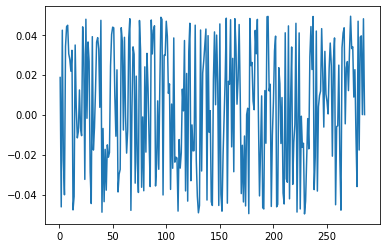

In [44]:
plt.plot(tau_list)

In [82]:
refsig = np.linspace(1, 10, 10)
for i in range(0, 10):
    sig = np.concatenate((np.linspace(0, 0, i), refsig, np.linspace(0, 0, 10 - i)))
    refsig = np.concatenate((refsig, np.linspace(0, 0, 10)))
    tau, cc, R, SIG1, SIG2 = gcc_phat(sig[0:16], refsig[0:16], fs = 1, max_tau = 10, interp = 4, window = True, windowName = "hamming")
    print(tau)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
6.0
6.0
-1.0
